## RLP vs Cross Entropy MNIST

In [ ]:
# Step 1: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

torch.manual_seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Step 2: Data Preparation
transform = transforms.Compose([
    transforms.Pad(2),  # Pad images to achieve 32x32 size
    transforms.ToTensor(),
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

## Take the first 5000 data points
train_dataset = Subset(train_dataset, indices=range(100)) # 5000
test_dataset = Subset(test_dataset, indices=range(5000))  # 5000

train_loader = DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = F.avg_pool2d(x, 2, stride=2)
        x = torch.tanh(self.conv2(x))
        x = F.avg_pool2d(x, 2, stride=2)
        x = x.view(-1, 16*5*5)  # Flatten
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

def balanced_batch_generator_mnist(data, labels, M, K):
    num_samples = len(data)
    selected_batches = set()
    all_indices = np.arange(num_samples)

    # Make sure each data point is in at least one batch
    np.random.shuffle(all_indices)

    # Sample until we obtain K unique batches
    while len(selected_batches) < K:
        # Generate indices and shuffle them
        all_indices = np.arange(num_samples)
        np.random.shuffle(all_indices)

        # Iterate over data and form batches of size M
        for i in range(0, num_samples, M):
            batch_indices = tuple(sorted(all_indices[i:i+M]))
            if batch_indices not in selected_batches:
                if i + M > num_samples:  # skip batches smaller than N
                    continue
                selected_batches.add(batch_indices)

            if len(selected_batches) >= K:
                break

    # Transform the set to a list
    selected_batches = list(selected_batches)

    # Yield data batches with their labels
    for indices in selected_batches:
        yield data[np.array(indices)], labels[np.array(indices)]

iterations = 5
num_epochs = 50
batch_size = 50 # 28*28+1
num_batches = 100

accuracy_bce_array = np.zeros((num_epochs, iterations))
recall_bce_array = np.zeros((num_epochs, iterations))
accuracy_rlp_array = np.zeros((num_epochs, iterations))
recall_rlp_array = np.zeros((num_epochs, iterations))

X_train_list, y_train_list = [], []
for data, labels in train_loader:
    X_train_list.append(data)
    y_train_list.append(labels)

X_train = torch.cat(X_train_list, dim=0)
y_train = torch.cat(y_train_list, dim=0)
y_train_hot = F.one_hot(y_train.long(), num_classes=10).float().to(device)

X_test_list, y_test_list = [], []
for data, labels in test_loader:
    X_test_list.append(data)
    y_test_list.append(labels)

X_test = torch.cat(X_test_list, dim=0)
y_test = torch.cat(y_test_list, dim=0)
y_test_hot = F.one_hot(y_test.long(), num_classes=10).float().to(device)

X_train = X_train.to(device); y_train_hot = y_train_hot.to(device);
X_test = X_test.to(device); y_test = y_test.to(device);
criterion_rlp = nn.MSELoss()
criterion_bce = nn.BCELoss()

for i in range(iterations):
    model_bce = LeNet5()
    model_rlp = LeNet5()
    model_bce = model_bce.to(device)
    model_rlp = model_rlp.to(device)

    optimizer_bce = optim.AdamW(model_bce.parameters(), lr=2e-3)
    optimizer_rlp = optim.AdamW(model_rlp.parameters(), lr=2e-3)

    train_dataset = TensorDataset(X_train, y_train_hot)
    train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
    unique_batches = list(balanced_batch_generator_mnist(X_train, y_train_hot, batch_size, num_batches))

    for epoch in range(num_epochs):
        # Training loop for BCE
        for batch_X, batch_y in train_dataloader:
            optimizer_bce.zero_grad()
            outputs_bce = model_bce(batch_X)
            loss_bce = criterion_bce(outputs_bce, batch_y)
            loss_bce.backward()
            optimizer_bce.step()

        # Training loop for RLP
        for batch_X, batch_y in unique_batches:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            model_rlp.train()
            optimizer_rlp.zero_grad()
            outputs_rlp = model_rlp(batch_X)

            # Reshape batch_X for matrix operations
            batch_X_reshaped = batch_X.view(batch_X.size(0), -1)

            # Compute pseudo-inverse
            reg_matrix = torch.linalg.pinv(batch_X_reshaped.transpose(0, 1) @ batch_X_reshaped) @ batch_X_reshaped.transpose(0, 1)
            # Matrix multiplications
            c = reg_matrix @ batch_y
            c_pred = reg_matrix @ outputs_rlp

            loss_rlp = criterion_rlp(batch_X_reshaped @ c_pred , batch_X_reshaped @ c )
            loss_rlp.backward()
            optimizer_rlp.step()

        # Evaluation for BCE
        with torch.no_grad():
            outputs_bce_test = model_bce(X_test)
            _, predicted_bce = torch.max(outputs_bce_test, 1)
            accuracy_bce_array[epoch,i] = (predicted_bce == y_test).sum().item() / len(y_test) * 100
            recall_bce_array[epoch,i] = f1_score(y_test.cpu().numpy(), predicted_bce.cpu().numpy(), average='macro')

        # Evaluation for RLP
        with torch.no_grad():
            outputs_rlp_test = model_rlp(X_test)
            _, predicted_rlp = torch.max(outputs_rlp_test, 1)
            accuracy_rlp_array[epoch,i] = (predicted_rlp == y_test).sum().item() / len(y_test) * 100
            recall_rlp_array[epoch,i] = f1_score(y_test.cpu().numpy(), predicted_rlp.cpu().numpy(), average='macro')

        print(f'Epoch: {epoch}, BCE Accuracy: {accuracy_bce_array[epoch,i]}, BCE Recall: {recall_bce_array[epoch,i]}')
        print(f'Epoch: {epoch}, RLP Accuracy: {accuracy_rlp_array[epoch,i]}, RLP Recall: {recall_rlp_array[epoch,i]}')

cuda
Epoch: 0, BCE Accuracy: 14.000000000000002, BCE Recall: 0.07510620220900595
Epoch: 0, RLP Accuracy: 74.0, RLP Recall: 0.6982873851294904
Epoch: 1, BCE Accuracy: 26.0, BCE Recall: 0.16805860805860806
Epoch: 1, RLP Accuracy: 78.0, RLP Recall: 0.7425562800207831
Epoch: 2, BCE Accuracy: 25.0, BCE Recall: 0.18094474153297685
Epoch: 2, RLP Accuracy: 74.0, RLP Recall: 0.6881756756756757
Epoch: 3, BCE Accuracy: 23.0, BCE Recall: 0.1632136752136752
Epoch: 3, RLP Accuracy: 73.0, RLP Recall: 0.6798361183553882
Epoch: 4, BCE Accuracy: 28.000000000000004, BCE Recall: 0.192046783625731
Epoch: 4, RLP Accuracy: 73.0, RLP Recall: 0.6798361183553882
Epoch: 5, BCE Accuracy: 42.0, BCE Recall: 0.31084301779435836
Epoch: 5, RLP Accuracy: 73.0, RLP Recall: 0.6798361183553882
Epoch: 6, BCE Accuracy: 52.0, BCE Recall: 0.37711413858472675
Epoch: 6, RLP Accuracy: 74.0, RLP Recall: 0.6774613757948871
Epoch: 7, BCE Accuracy: 56.00000000000001, BCE Recall: 0.40210606060606063
Epoch: 7, RLP Accuracy: 74.0, RLP 

Epoch: 16, BCE Accuracy: 65.0, BCE Recall: 0.5333745348219032
Epoch: 16, RLP Accuracy: 76.0, RLP Recall: 0.710100744002272
Epoch: 17, BCE Accuracy: 65.0, BCE Recall: 0.5366296821252065
Epoch: 17, RLP Accuracy: 76.0, RLP Recall: 0.710100744002272
Epoch: 18, BCE Accuracy: 64.0, BCE Recall: 0.5273140578933263
Epoch: 18, RLP Accuracy: 76.0, RLP Recall: 0.710100744002272
Epoch: 19, BCE Accuracy: 67.0, BCE Recall: 0.5443466952264382
Epoch: 19, RLP Accuracy: 76.0, RLP Recall: 0.710100744002272
Epoch: 20, BCE Accuracy: 69.0, BCE Recall: 0.5984404008632846
Epoch: 20, RLP Accuracy: 76.0, RLP Recall: 0.710100744002272
Epoch: 21, BCE Accuracy: 69.0, BCE Recall: 0.5984404008632846
Epoch: 21, RLP Accuracy: 76.0, RLP Recall: 0.710100744002272
Epoch: 22, BCE Accuracy: 69.0, BCE Recall: 0.598863566407418
Epoch: 22, RLP Accuracy: 76.0, RLP Recall: 0.710100744002272
Epoch: 23, BCE Accuracy: 70.0, BCE Recall: 0.615749082851758
Epoch: 23, RLP Accuracy: 76.0, RLP Recall: 0.710100744002272
Epoch: 24, BCE Acc

Epoch: 33, BCE Accuracy: 72.0, BCE Recall: 0.6388984834678881
Epoch: 33, RLP Accuracy: 74.0, RLP Recall: 0.6738852755194218
Epoch: 34, BCE Accuracy: 73.0, BCE Recall: 0.6488804897656839
Epoch: 34, RLP Accuracy: 74.0, RLP Recall: 0.6738852755194218
Epoch: 35, BCE Accuracy: 72.0, BCE Recall: 0.6358014988641123
Epoch: 35, RLP Accuracy: 74.0, RLP Recall: 0.6738852755194218
Epoch: 36, BCE Accuracy: 72.0, BCE Recall: 0.6360739603207842
Epoch: 36, RLP Accuracy: 74.0, RLP Recall: 0.6738852755194218
Epoch: 37, BCE Accuracy: 72.0, BCE Recall: 0.6360739603207842
Epoch: 37, RLP Accuracy: 74.0, RLP Recall: 0.6738852755194218
Epoch: 38, BCE Accuracy: 71.0, BCE Recall: 0.6260919540229886
Epoch: 38, RLP Accuracy: 74.0, RLP Recall: 0.6738852755194218
Epoch: 39, BCE Accuracy: 71.0, BCE Recall: 0.6260919540229886
Epoch: 39, RLP Accuracy: 74.0, RLP Recall: 0.6738852755194218
Epoch: 40, BCE Accuracy: 71.0, BCE Recall: 0.6260919540229886
Epoch: 40, RLP Accuracy: 74.0, RLP Recall: 0.6738852755194218
Epoch: 4

Epoch: 0, BCE Accuracy: 23.0, BCE Recall: 0.10188424393867765
Epoch: 0, RLP Accuracy: 75.0, RLP Recall: 0.7014733562464961
Epoch: 1, BCE Accuracy: 27.0, BCE Recall: 0.1459288402326377
Epoch: 1, RLP Accuracy: 73.0, RLP Recall: 0.6842506841817186
Epoch: 2, BCE Accuracy: 22.0, BCE Recall: 0.08951219512195123
Epoch: 2, RLP Accuracy: 75.0, RLP Recall: 0.6967674106689387
Epoch: 3, BCE Accuracy: 23.0, BCE Recall: 0.10793490460157126
Epoch: 3, RLP Accuracy: 75.0, RLP Recall: 0.6978825917841199
Epoch: 4, BCE Accuracy: 30.0, BCE Recall: 0.20608776844070958
Epoch: 4, RLP Accuracy: 75.0, RLP Recall: 0.6978825917841199
Epoch: 5, BCE Accuracy: 43.0, BCE Recall: 0.3080872000974303
Epoch: 5, RLP Accuracy: 75.0, RLP Recall: 0.6978825917841199
Epoch: 6, BCE Accuracy: 47.0, BCE Recall: 0.32998280013759884
Epoch: 6, RLP Accuracy: 75.0, RLP Recall: 0.6978825917841199
Epoch: 7, BCE Accuracy: 51.0, BCE Recall: 0.3657350157591172
Epoch: 7, RLP Accuracy: 75.0, RLP Recall: 0.6978825917841199
Epoch: 8, BCE Accur

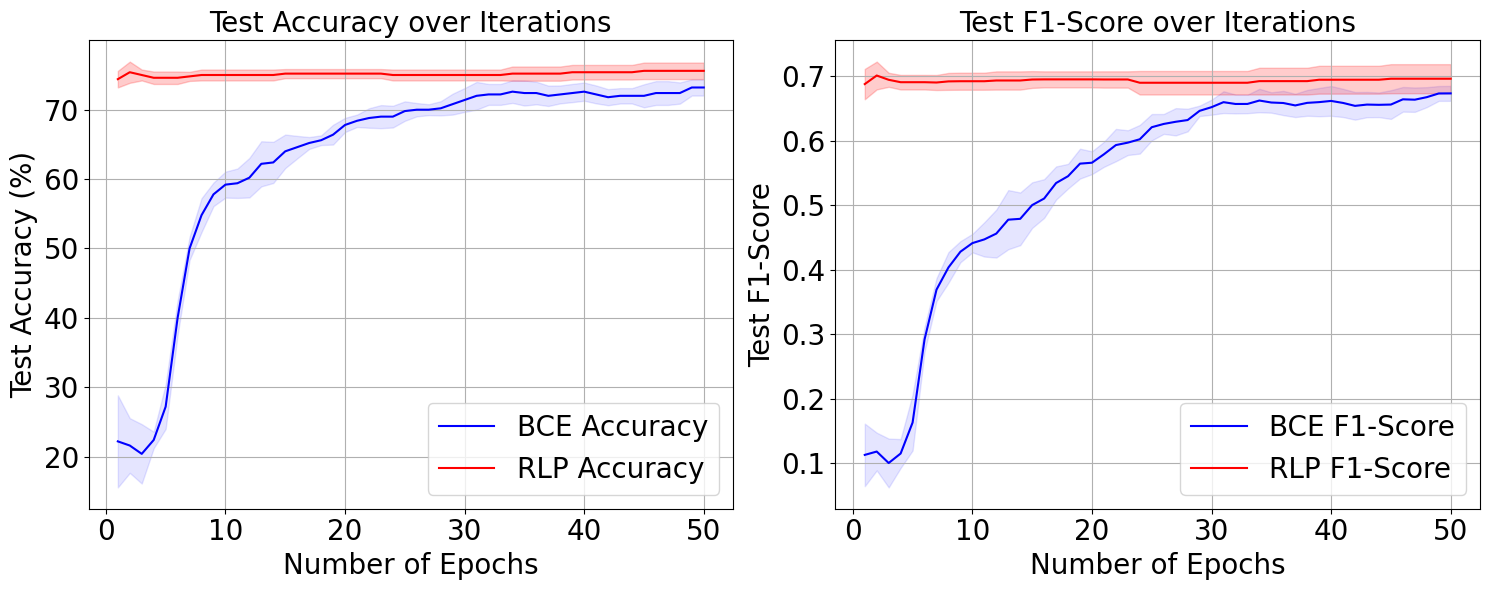

In [ ]:
# Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=1)
    std_error = np.std(data, axis=1) / np.sqrt(data.shape[1])  # Standard error of the mean
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci

# Calculate means and confidence intervals for accuracy and recall
mean_accuracy_bce, ci_accuracy_bce = compute_mean_and_CI(accuracy_bce_array)
mean_accuracy_rlp, ci_accuracy_rlp = compute_mean_and_CI(accuracy_rlp_array)
mean_recall_bce, ci_recall_bce = compute_mean_and_CI(recall_bce_array)
mean_recall_rlp, ci_recall_rlp = compute_mean_and_CI(recall_rlp_array)

# Plot the results
epochs_range = list(range(1, num_epochs + 1))
plt.figure(figsize=(15, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
# BCE Accuracy
plt.fill_between(epochs_range, mean_accuracy_bce - ci_accuracy_bce, mean_accuracy_bce + ci_accuracy_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_accuracy_bce, 'b-', label="BCE Accuracy", zorder=15)

# RLP Accuracy
plt.fill_between(epochs_range, mean_accuracy_rlp - ci_accuracy_rlp, mean_accuracy_rlp + ci_accuracy_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_accuracy_rlp, 'r-', label="RLP Accuracy", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test Accuracy (%)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.grid(True)
plt.title('Test Accuracy over Iterations', fontsize=20)

# Plotting recall
plt.subplot(1, 2, 2)
# BCE Recall
plt.fill_between(epochs_range, mean_recall_bce - ci_recall_bce, mean_recall_bce + ci_recall_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_recall_bce, 'b-', label="BCE F1-Score", zorder=15)

# RLP Recall
plt.fill_between(epochs_range, mean_recall_rlp - ci_recall_rlp, mean_recall_rlp + ci_recall_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_recall_rlp, 'r-', label="RLP F1-Score", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test F1-Score", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.grid(True)
plt.title('Test F1-Score over Iterations', fontsize=20)

plt.tight_layout()
plt.show()

## RLP vs Cross Entropy on top of MIXUP data augmentation

In [ ]:
# Step 1: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

torch.manual_seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Step 2: Data Preparation
transform = transforms.Compose([
    transforms.Pad(2),  # Pad images to achieve 32x32 size
    transforms.ToTensor(),
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

## Take the first 5000 data points
train_dataset = Subset(train_dataset, indices=range(100)) # 5000
test_dataset = Subset(test_dataset, indices=range(5000))   # 5000

train_loader = DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = F.avg_pool2d(x, 2, stride=2)
        x = torch.tanh(self.conv2(x))
        x = F.avg_pool2d(x, 2, stride=2)
        x = x.view(-1, 16*5*5)  # Flatten
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

def balanced_batch_generator_mnist(data, labels, M, K):
    num_samples = len(data)
    selected_batches = set()
    all_indices = np.arange(num_samples)

    # Make sure each data point is in at least one batch
    np.random.shuffle(all_indices)

    # Sample until we obtain K unique batches
    while len(selected_batches) < K:
        # Generate indices and shuffle them
        all_indices = np.arange(num_samples)
        np.random.shuffle(all_indices)

        # Iterate over data and form batches of size M
        for i in range(0, num_samples, M):
            batch_indices = tuple(sorted(all_indices[i:i+M]))
            if batch_indices not in selected_batches:
                if i + M > num_samples:  # skip batches smaller than N
                    continue
                selected_batches.add(batch_indices)

            if len(selected_batches) >= K:
                break

    # Transform the set to a list
    selected_batches = list(selected_batches)

    # Yield data batches with their labels
    for indices in selected_batches:
        yield data[np.array(indices)], labels[np.array(indices)]

iterations = 5
num_epochs = 50
batch_size = 50 # 28*28+1
num_batches = 100

accuracy_bce_array = np.zeros((num_epochs, iterations))
recall_bce_array = np.zeros((num_epochs, iterations))
accuracy_rlp_array = np.zeros((num_epochs, iterations))
recall_rlp_array = np.zeros((num_epochs, iterations))

X_train_list, y_train_list = [], []
for data, labels in train_loader:
    X_train_list.append(data)
    y_train_list.append(labels)

X_train = torch.cat(X_train_list, dim=0)
y_train = torch.cat(y_train_list, dim=0)
y_train_hot = F.one_hot(y_train.long(), num_classes=10).float().to(device)

X_test_list, y_test_list = [], []
for data, labels in test_loader:
    X_test_list.append(data)
    y_test_list.append(labels)

X_test = torch.cat(X_test_list, dim=0)
y_test = torch.cat(y_test_list, dim=0)
y_test_hot = F.one_hot(y_test.long(), num_classes=10).float().to(device)

X_train = X_train.to(device); y_train_hot = y_train_hot.to(device);
X_test = X_test.to(device); y_test = y_test.to(device);
criterion_rlp = nn.MSELoss()
criterion_bce = nn.BCELoss()

for i in range(iterations):
    model_bce = LeNet5()
    model_rlp = LeNet5()
    model_bce = model_bce.to(device)
    model_rlp = model_rlp.to(device)

    optimizer_bce = optim.AdamW(model_bce.parameters(), lr=2e-3)
    optimizer_rlp = optim.AdamW(model_rlp.parameters(), lr=2e-3)

    train_dataset = TensorDataset(X_train, y_train_hot)
    train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
    train_dataloader_2 = DataLoader(train_dataset, batch_size=1000, shuffle=True)
    unique_batches = list(balanced_batch_generator_mnist(X_train, y_train_hot, batch_size, num_batches))
    unique_batches_2 = list(balanced_batch_generator_mnist(X_train, y_train_hot, batch_size, num_batches))

    for epoch in range(num_epochs):
        # Training loop for BCE
        for (batch_X, batch_y), (batch_X2, batch_y2) in zip(train_dataloader, train_dataloader_2):
            model_bce.train()
            alpha = 0.2
            lam = np.random.beta(alpha, alpha)
            x = lam * batch_X + (1. - lam) * batch_X2
            y = lam * batch_y + (1. - lam) * batch_y2
            x, y = x.to(device), y.to(device)

            optimizer_bce.zero_grad()
            outputs = model_bce(x)
            loss_bce = criterion_bce(outputs, y)
            loss_bce.backward()
            optimizer_bce.step()

        # Training loop for RLP
        for (batch_X, batch_y), (batch_X2, batch_y2) in zip(unique_batches, unique_batches_2):
            model_rlp.train()
            alpha = 0.2
            lam = np.random.beta(alpha, alpha)
            x = lam * batch_X + (1. - lam) * batch_X2
            y = lam * batch_y + (1. - lam) * batch_y2
            x, y = x.to(device), y.to(device)

            optimizer_rlp.zero_grad()
            outputs_rlp = model_rlp(x)

            # Reshape batch_X for matrix operations
            x = x.view(batch_X.size(0), -1)

            # Compute pseudo-inverse
            reg_matrix = torch.linalg.pinv(x.transpose(0, 1) @ x) @ x.transpose(0, 1)
            # Matrix multiplications
            c = reg_matrix @ y
            c_pred = reg_matrix @ outputs_rlp

            loss_rlp = criterion_rlp(x @ c_pred, x @ c)
            loss_rlp.backward()
            optimizer_rlp.step()

        # Evaluation for BCE
        with torch.no_grad():
            outputs_bce_test = model_bce(X_test)
            _, predicted_bce = torch.max(outputs_bce_test, 1)
            accuracy_bce_array[epoch,i] = (predicted_bce == y_test).sum().item() / len(y_test) * 100
            recall_bce_array[epoch,i] = f1_score(y_test.cpu().numpy(), predicted_bce.cpu().numpy(), average='macro')

        # Evaluation for RLP
        with torch.no_grad():
            outputs_rlp_test = model_rlp(X_test)
            _, predicted_rlp = torch.max(outputs_rlp_test, 1)
            accuracy_rlp_array[epoch,i] = (predicted_rlp == y_test).sum().item() / len(y_test) * 100
            recall_rlp_array[epoch,i] = f1_score(y_test.cpu().numpy(), predicted_rlp.cpu().numpy(), average='macro')

        print(f'Epoch: {epoch}, BCE Accuracy: {accuracy_bce_array[epoch,i]}, BCE Recall: {recall_bce_array[epoch,i]}')
        print(f'Epoch: {epoch}, RLP Accuracy: {accuracy_rlp_array[epoch,i]}, RLP Recall: {recall_rlp_array[epoch,i]}')

cpu
Epoch: 0, BCE Accuracy: 15.68, BCE Recall: 0.07292910863429583
Epoch: 0, RLP Accuracy: 73.8, RLP Recall: 0.7114217414780104
Epoch: 1, BCE Accuracy: 30.740000000000002, BCE Recall: 0.26385919304494465
Epoch: 1, RLP Accuracy: 72.08, RLP Recall: 0.7017207587564813
Epoch: 2, BCE Accuracy: 41.32, BCE Recall: 0.3192714284409198
Epoch: 2, RLP Accuracy: 73.4, RLP Recall: 0.72136504203
Epoch: 3, BCE Accuracy: 44.86, BCE Recall: 0.350511879481473
Epoch: 3, RLP Accuracy: 73.36, RLP Recall: 0.7234419907660523
Epoch: 4, BCE Accuracy: 47.32, BCE Recall: 0.39511193861538063
Epoch: 4, RLP Accuracy: 75.03999999999999, RLP Recall: 0.7373938586405233
Epoch: 5, BCE Accuracy: 49.18, BCE Recall: 0.4186464246995529
Epoch: 5, RLP Accuracy: 75.06, RLP Recall: 0.7383232548825831
Epoch: 6, BCE Accuracy: 50.03999999999999, BCE Recall: 0.4291913289488522
Epoch: 6, RLP Accuracy: 72.78, RLP Recall: 0.7157745064133912
Epoch: 7, BCE Accuracy: 50.42, BCE Recall: 0.4374743603488039
Epoch: 7, RLP Accuracy: 71.22, RLP

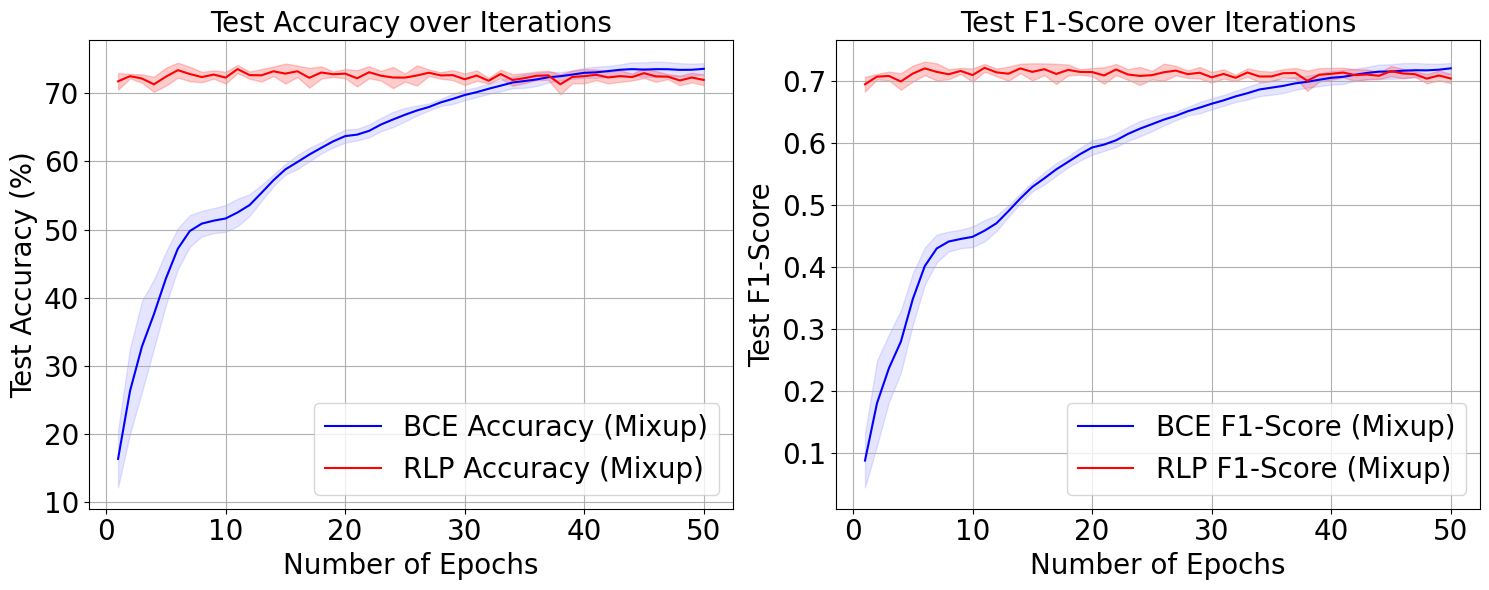

In [ ]:
# Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=1)
    std_error = np.std(data, axis=1) / np.sqrt(data.shape[1])  # Standard error of the mean
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci

# Calculate means and confidence intervals for accuracy and recall
mean_accuracy_bce, ci_accuracy_bce = compute_mean_and_CI(accuracy_bce_array)
mean_accuracy_rlp, ci_accuracy_rlp = compute_mean_and_CI(accuracy_rlp_array)
mean_recall_bce, ci_recall_bce = compute_mean_and_CI(recall_bce_array)
mean_recall_rlp, ci_recall_rlp = compute_mean_and_CI(recall_rlp_array)

# Plot the results
epochs_range = list(range(1, num_epochs + 1))
plt.figure(figsize=(15, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
# BCE Accuracy
plt.fill_between(epochs_range, mean_accuracy_bce - ci_accuracy_bce, mean_accuracy_bce + ci_accuracy_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_accuracy_bce, 'b-', label="BCE Accuracy (Mixup)", zorder=15)

# RLP Accuracy
plt.fill_between(epochs_range, mean_accuracy_rlp - ci_accuracy_rlp, mean_accuracy_rlp + ci_accuracy_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_accuracy_rlp, 'r-', label="RLP Accuracy (Mixup)", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test Accuracy (%)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.grid(True)
plt.title('Test Accuracy over Iterations', fontsize=20)

# Plotting recall
plt.subplot(1, 2, 2)
# BCE Recall
plt.fill_between(epochs_range, mean_recall_bce - ci_recall_bce, mean_recall_bce + ci_recall_bce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_recall_bce, 'b-', label="BCE F1-Score (Mixup)", zorder=15)

# RLP Recall
plt.fill_between(epochs_range, mean_recall_rlp - ci_recall_rlp, mean_recall_rlp + ci_recall_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_recall_rlp, 'r-', label="RLP F1-Score (Mixup)", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test F1-Score", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.grid(True)
plt.title('Test F1-Score over Iterations', fontsize=20)

plt.tight_layout()
plt.show()